# Patient with WASP and ARPC1B deficient cells

In [1]:
library(ggplot2)
library(extrafont)
library(stringr)
library(heatmaply)
library(ggrepel)
library(reticulate)
library(gridExtra)
library(robustbase)
library(randomForest)
library(reshape2)

Registering fonts with R
Loading required package: plotly

Attaching package: ‘plotly’

The following object is masked from ‘package:ggplot2’:

    last_plot

The following object is masked from ‘package:stats’:

    filter

The following object is masked from ‘package:graphics’:

    layout

Loading required package: viridis
Loading required package: viridisLite

Welcome to heatmaply version 0.15.2

Type citation('heatmaply') for how to cite the package.
Type ?heatmaply for the main documentation.

The github page is: https://github.com/talgalili/heatmaply/
Please submit your suggestions and bug-reports at: https://github.com/talgalili/heatmaply/issues
Or contact: <tal.galili@gmail.com>

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:gridExtra’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin



In [2]:
# Load external Python functions
source_python("reticulate_functions.py")
# Load extra fonts
ttf_import(paths = "/tmp/.fonts/")
loadfonts()
# Set this to true for faster compilation or false for more precise results and all outputs
TEST_MODE = F

Scanning ttf files in /tmp/.fonts/ ...
Extracting .afm files from .ttf files...
/tmp/.fonts/Arial.ttf : ArialMT already registered in fonts database. Skipping.
Found FontName for 0 fonts.
Scanning afm files in /opt/conda/lib/R/library/extrafontdb/metrics
Warning message in grepl("^FamilyName", text):
“input string 4 is invalid in this locale”Warning message in grepl("^FontName", text):
“input string 4 is invalid in this locale”Warning message in grepl("^FullName", text):
“input string 4 is invalid in this locale”Warning message in grepl("^Weight", text):
“input string 4 is invalid in this locale”Arial already registered with pdfFonts().


In [3]:
# Number of permutations used for empirical p-value computations
PERM_NB_ITER = ifelse(TEST_MODE, 20, 2000)
# Number of trees used in random forest classifier
RF_NB_TREES = ifelse(TEST_MODE, 50, 1000)

In [4]:
# Customize ggplot appearance

# Change theme
customTheme <- theme_light() + 
               theme(panel.grid.minor=element_blank(), text=element_text(size=17, family="Arial", colour = "#333333"),
                     line=element_line(colour = "#333333"), legend.background = element_rect(fill=alpha('#CCCCCC', 0.1)), legend.key = element_blank())

# Change default colors
scale_colour_continuous <- function (..., begin = 0.1, end = 0.9, direction = -1, option = "plasma", 
                                     type = getOption("ggplot2.continuous.colour", default = "viridis")) {
    switch(type, gradient = scale_colour_gradient(...), 
        viridis = scale_colour_viridis_c(option = option, begin = begin, end = end, direction = direction, ...), 
        stop("Unknown scale type", call. = FALSE))
}
scale_color_continuous <- scale_colour_continuous

scale_fill_continuous <- function (..., begin = 0.1, end = 0.9, direction = -1, option = "plasma", 
                                     type = getOption("ggplot2.continuous.colour", default = "viridis")) {
    switch(type, gradient = scale_fill_gradient(...), 
        viridis = scale_fill_viridis_c(option = option, begin = begin, end = end, direction = direction, ...), 
        stop("Unknown scale type", call. = FALSE))

}

cemm_pal = colorRampPalette(c("#5A463C", "#008CAD", "#40B9D4", "#D4ECF2", "#D2323C", "#F8B100", "#DFDC00"))
cust_pal = colorRampPalette(c("#008CAD", "#40B9D4", "#D4ECF2", "#F8B100", "#C00000", "#2D0000"))
yolla_pal = colorRampPalette(c('#FC7070', '#C00000', '#2D0000'))
scale_fill_discrete <- function (..., type = "Cust", h = c(0, 360) + 15, c = 100, l = 65, h.start = 0, 
    direction = 1, na.value = "grey50", aesthetics = "fill") 
{
    if (type == "CeMM"){
        discrete_scale(aesthetics, "CeMM", cemm_pal, na.value = na.value, ...)
    } else if (type == "Yolla"){
        discrete_scale(aesthetics, "Yolla", yolla_pal, na.value = na.value, ...)
    } else if (type == "Cust"){
        discrete_scale(aesthetics, "Cust", cust_pal, na.value = na.value, ...)
    } else {
        discrete_scale(aesthetics, "hue", hue_pal(h, c, l, h.start, 
            direction), na.value = na.value, ...)
    }
}

scale_color_discrete <- function (..., type = "Cust", h = c(0, 360) + 15, c = 100, l = 65, h.start = 0, 
    direction = 1, na.value = "grey50", aesthetics = "colour") {
    if (type == "CeMM"){
        discrete_scale(aesthetics, "CeMM", cemm_pal, na.value = na.value, ...)
    } else if (type == "Cust"){
        discrete_scale(aesthetics, "Cust", cust_pal, na.value = na.value, ...)
    } else if (type == "Yolla"){
        discrete_scale(aesthetics, "Yolla", yolla_pal, na.value = na.value, ...)
    } else {
        discrete_scale(aesthetics, "hue", scales::hue_pal(h, c, l, h.start, 
            direction), na.value = na.value, ...)
    }
}
scale_colour_discrete <- scale_color_discrete

noGridTheme <- function(...){
    theme(panel.grid.major=element_blank(), axis.text.x=element_text(size=12), axis.text.y=element_text(size=12),
                      axis.line=element_line(color="#333333", size = 0.2), panel.border = element_blank(), ...)
}

darkTheme <- function(...){
    theme(panel.background = element_rect(fill = '#333333'), plot.background = element_rect(fill = '#333333'), 
          axis.line=element_line(color="#CCCCCC", size = 0.2), 
          text=element_text(size=17, family="Arial", colour = "#CCCCCC"),
          line=element_line(colour = "#CCCCCC"))
}

theme_set(customTheme)

options(repr.plot.width=10, repr.plot.height=10)

## Patient cells (∆ARPC1B, ∆WAS)

In [5]:
# Fix t-SNE layout and random number generation
set.seed(38)

In [6]:
LT = read.csv("Rsc/compiled_LT_2Diseases_Image.csv", header=T)

In [7]:
LT_intensities = read.csv("Rsc/compiled_LT_2Diseases_ExtraIntensity_Image.csv", header=T)

In [8]:
dim(LT)

[1] 1872 2442

In [9]:
dim(LT_intensities)

[1] 1872  266

In [10]:
# Images in both runs should be recorded in the same order
all(LT_intensities$URL_DNA == LT$URL_DNA)
# Sanity check
all(LT$Count_FinalNucleus == LT_intensities$Count_FinalNucleus, na.rm=T)

[1] TRUE

[1] TRUE

In [11]:
newFt = !(names(LT_intensities) %in% names(LT))
newFt = newFt | names(LT_intensities) == "URL_DNA"

In [12]:
LT = merge(LT, LT_intensities[,newFt], by = "URL_DNA")

In [13]:
getPLL <- function(row,column){
    return(column<=6)
}
getDonor <- function(row,column){
    # Donors are grouped by square of 4 wells, repeated 4
    # times with 3 empty well groups in between each time
    return((ceiling(row/2) + 8*(ceiling(column/2)-1)) %% 12)
}
getDeficiency <- function(donor){
    if (donor %in% c(1,7,4)){
        return("ND")
    }
    else if (donor %in% c(6,3,9)){
        return("ARPC1B")
    }
    else if (donor %in% c(2,8,5)){
        return("WAS")
    }
}
LT$Donor = mapply(getDonor, LT$Metadata_Row, LT$Metadata_Column)
LT$PLL = mapply(getPLL, LT$Metadata_Row, LT$Metadata_Column)
LT$Deficiency = sapply(LT$Donor, getDeficiency)
# Is normal donor?
LT$ND = LT$Deficiency == "ND"

We discard the data from the PLL coated plates (not studied in this analysis).

In [14]:
LT = LT[!LT$PLL,]

Saving 6.67 x 6.67 in image


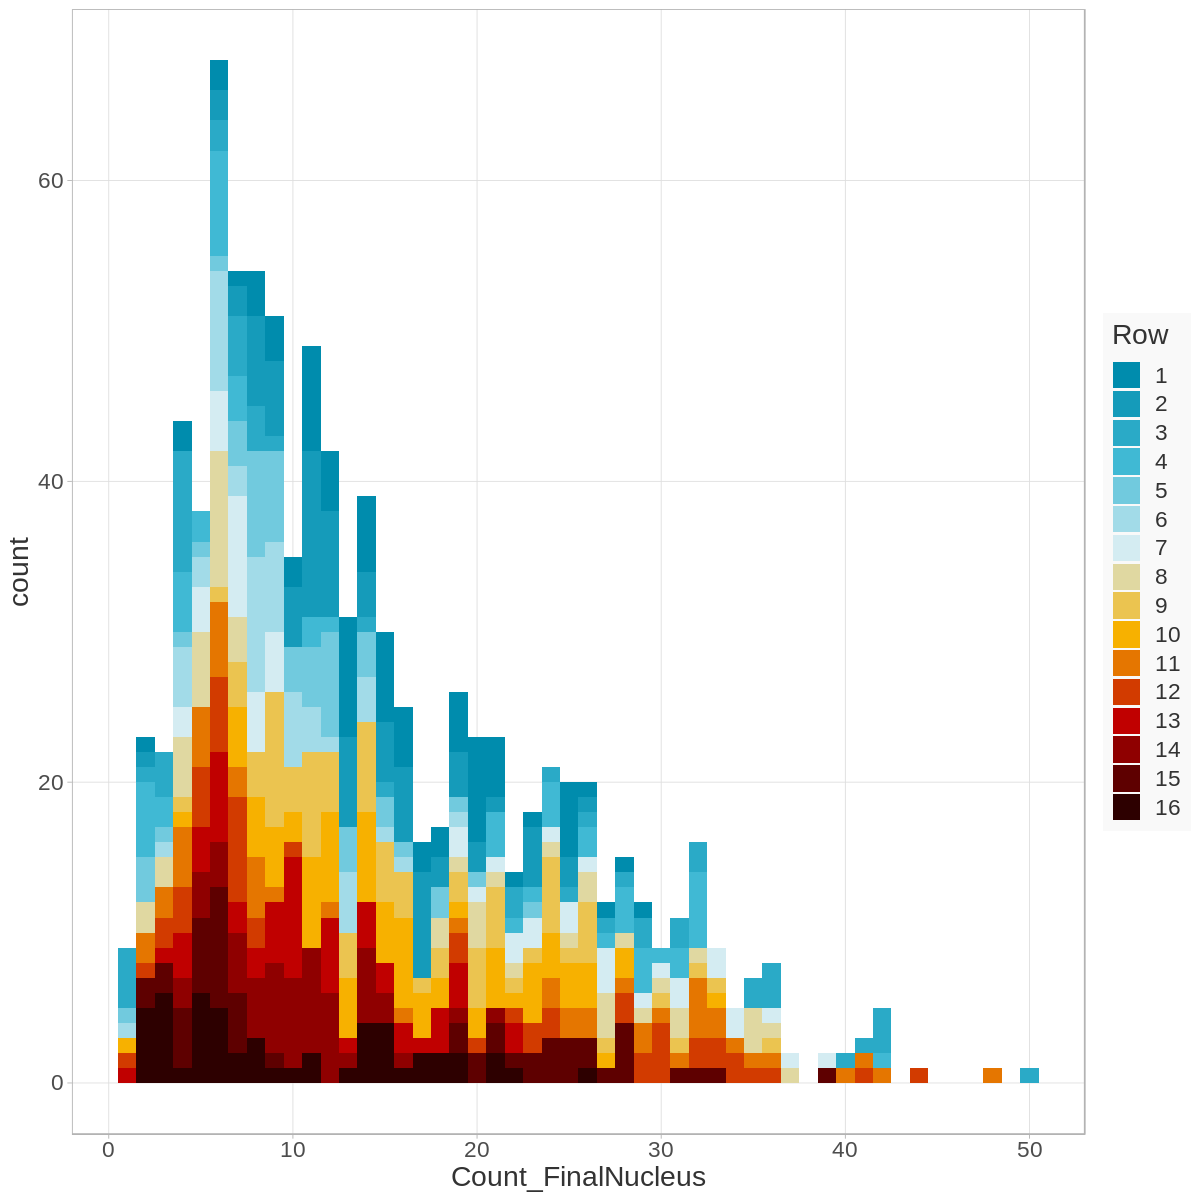

In [15]:
gpLT = ggplot(LT[!is.na(LT$Count_FinalNucleus),]) + geom_histogram(aes(Count_FinalNucleus, 
                                                                   fill = as.factor(Metadata_Row)), 
                                                                   binwidth=1) +
       scale_fill_discrete(name="Row")
gpLT
if(!TEST_MODE){
    ggsave(filename = "Fig/LT_2Deficiencies_count.pdf", plot = gpLT)
}

Saving 6.67 x 6.67 in image


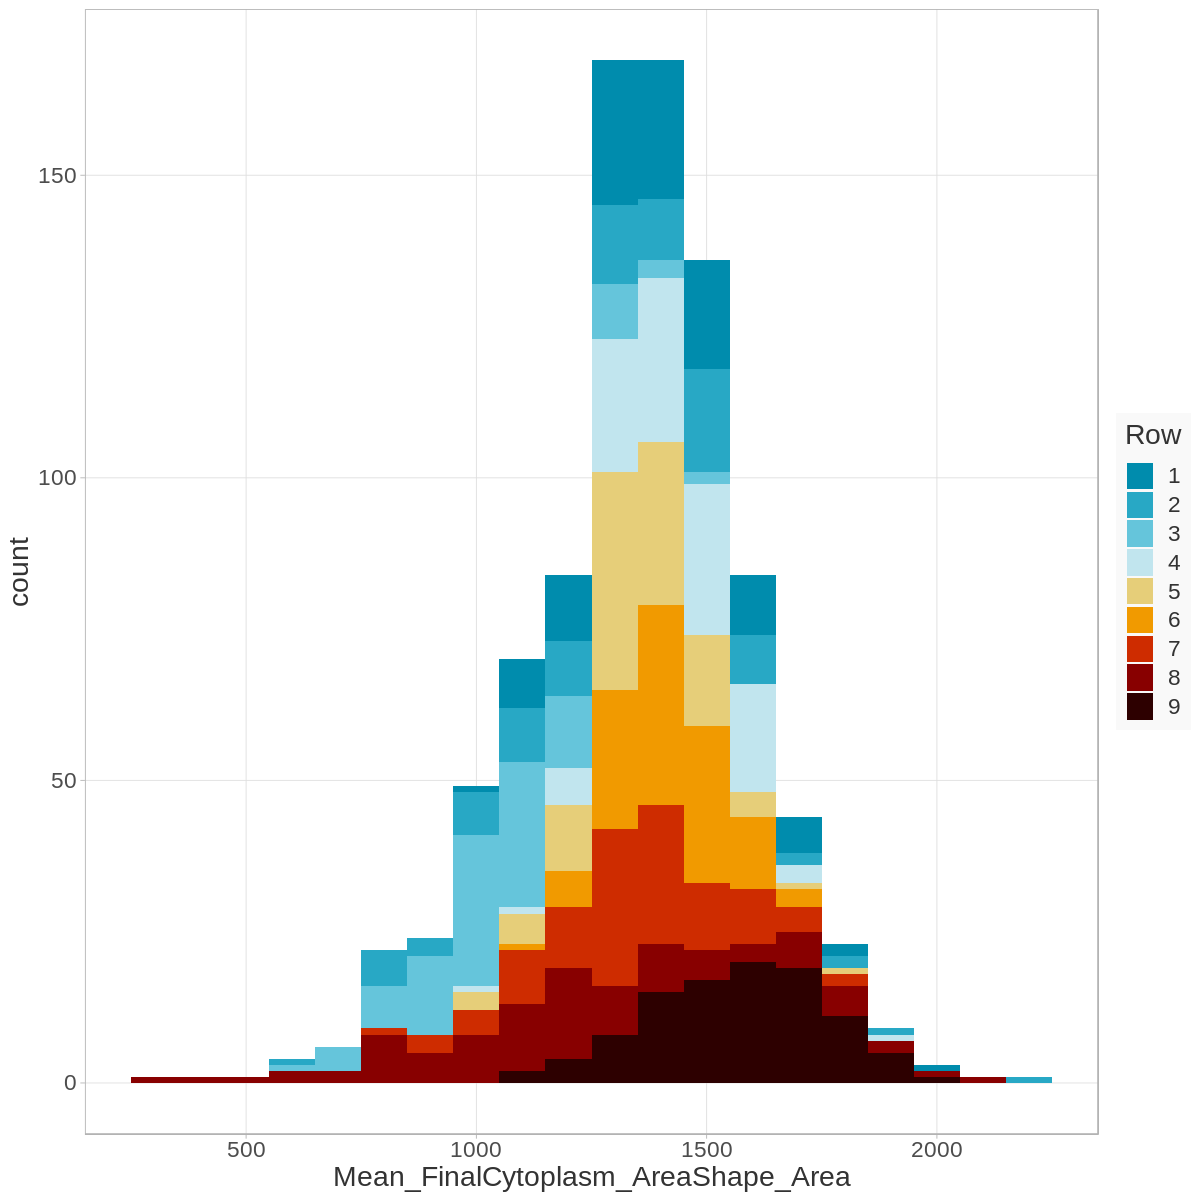

In [16]:
gpLT = ggplot(LT[!is.na(LT$Mean_FinalCytoplasm_AreaShape_Area),]) + 
    geom_histogram(aes(Mean_FinalCytoplasm_AreaShape_Area, 
                   fill = as.factor(Donor)), binwidth=100) +
       scale_fill_discrete(name="Row")
gpLT
if(!TEST_MODE){
    ggsave(filename = "Fig/LT_2Deficiencies_area.pdf", plot = gpLT)
}

### Filtering

In [17]:
FILT_MAX_INT_DNA = 0.01 # Remove empty images and small DNA precipitations
FILT_MIN_CELLS = 4 # Most field of views have only 2 cells
FILT_NB_MAX_NA_IMAGE = 1
FILT_MAX_CORR = 0.6 # Keep uncorrelated variables
FILT_MIN_PERF_NEIGHB = 1
dimUMAP = 10

In [18]:
ftToKeep = 1:dim(LT)[2]
# Make sure that the fields are numeric
ftToKeep <- ftToKeep[which(sapply(LT[,ftToKeep], class) == "numeric")]
# Remove execution time and count features
ftToKeep <- ftToKeep[grep(
            "(Execution)|(Count)|(Concentration)|(ActinGranules)|(ImageQuality)|(PLL)|(Donor)|(ND)|(CD8)", 
                          colnames(LT)[ftToKeep], invert = T)]

In [19]:
# Store all remaining features before filtering for downstream comparison to selected set
preFiltFt = colnames(LT)[ftToKeep]

In [20]:
# Remove wells with low max DNA intensity
fieldToKeep <- which(LT$ImageQuality_MaxIntensity_DNA >= FILT_MAX_INT_DNA)
# Remove wells with low cell count
fieldToKeep <- na.omit(fieldToKeep[LT[fieldToKeep,]$Count_FinalNucleus >= FILT_MIN_CELLS])

In [21]:
# For now images without perforin granules are filtered out (90 images removed)
# names(LT)[ftToKeep][is.na(LT[43,ftToKeep])]
# Few bad quality pictures are generating a lot of missing values and are removed
fieldToKeep <- fieldToKeep[rowSums(is.na(LT[fieldToKeep,ftToKeep])) < FILT_NB_MAX_NA_IMAGE]

In [22]:
# Only few images have no variation in perforin granule neighbors which biases the morphological space 
fieldToKeep <- fieldToKeep[LT$StDev_PerfGranules_Neighbors_PercentTouching_10[fieldToKeep] > FILT_MIN_PERF_NEIGHB]

In [23]:
# Remove remaining features with missing values
ftToKeep <- ftToKeep[colSums(is.na(LT[fieldToKeep,ftToKeep])) == 0] 
# Remove constant columns
indWT = LT[fieldToKeep,]$ND
ftToKeep <- ftToKeep[sapply(LT[fieldToKeep,ftToKeep], function(x) mad(x) != 0)]
ftToKeep <- ftToKeep[sapply(LT[fieldToKeep[indWT],ftToKeep], function(x) mad(x) != 0)]

In [24]:
# Approximate normal distribution
transfLog <- function (x){
    minVal = min(x)
    return(log(x+1-minVal))
}

# Center and scale on control values
transfNorm <- function(x, y){
    return((x - median(y))/mad(y))
}

In [25]:
# Try centering on all healthy donors
transformedLT = apply(LT[fieldToKeep, ftToKeep], 2, transfLog)
transformedLT = apply(transformedLT, 2, function(x) transfNorm(x, x[indWT]))

In [26]:
# Order features from biggest mad to smallest mad
# Since features have mad(ND) = 1, it means that we rank features by how more variable they are
# for patients than for ND
orderFt = rev(order(apply(transformedLT, 2, mad)))

In [27]:
uncorrFt = uncorrelate(transformedLT, orderCol = orderFt-1, threshold = FILT_MAX_CORR)
uncorrFt = unlist(uncorrFt) + 1

In [28]:
transformedLT = transformedLT[,uncorrFt]

In [29]:
dim(LT)
dim(LT[fieldToKeep, ftToKeep])
dim(transformedLT)

[1]  936 2506

[1]  759 1780

[1] 759 306

### Export subset of features

For LT cells, the following features are selected and explored separately for their biological interpretability:
```
* Actin intensity/cell (mean/well): LT$Intensity_MeanIntensity_CorrActin_FilterCytoplasm
* Cell area: LT$Mean_FilterCytoplasm_AreaShape_Area
* Cell roundness: LT$Mean_FilterCytoplasm_AreaShape_FormFactor
* Cell width: LT$Mean_FilterCytoplasm_AreaShape_MajorAxisLength 
* Cell length: LT$Mean_FilterCytoplasm_AreaShape_MinorAxisLength
* Cell length to width ratio: LT$Mean_FilterCytoplasm_AreaShape_MinorAxisLength / LT$Mean_FilterCytoplasm_AreaShape_MajorAxisLength
* Average number of perforin granules / cell: LT$Count_PerfGranules  / LT$Count_FilterCytoplasm
* Perforin area / cell area: (LT$Count_PerfGranules * LT$Mean_PerfGranules_AreaShape_Area)  / (LT$Count_FilterCytoplasm * LT$Mean_FilterCytoplasm_AreaShape_Area)
* Perforin intensity: LT$Intensity_MeanIntensity_CorrPerf_FilterCytoplasm
* Perforin area: LT$Mean_PerfGranules_AreaShape_Area
* Nucleus intensity: LT$Intensity_MeanIntensity_CorrDNA_FilteredNucleus
* Nucleus area: LT$Mean_FilteredNucleus_AreaShape_Area
* Nucleus roundness: LT$Mean_FilteredNucleus_AreaShape_FormFactor
* Nucleus width: LT$Mean_FilteredNucleus_AreaShape_MajorAxisLength 
* Nucleus length: LT$Mean_FilteredNucleus_AreaShape_MinorAxisLength
* Nucleus ratio: LT$Mean_FilteredNucleus_AreaShape_MinorAxisLength / LT$Mean_FilteredNucleus_AreaShape_MajorAxisLength
* Nucleus area / cell area: (LT$Count_FilteredNucleus * LT$Mean_FilteredNucleus_AreaShape_Area)  / (LT$Count_FilterCytoplasm * LT$Mean_FilterCytoplasm_AreaShape_Area)
* LFA intensity: LT$Intensity_MeanIntensity_CorrLFA_FilterNKLFA
* LFA-Actin correlation: LT[fieldToKeep,]$Mean_FilterNKCytoplasm_Correlation_Correlation_CorrLFA_CorrActin
* LFA area: LT$Mean_FilterNKLFA_AreaShape_Area
* LFA area / cell area: LT$Mean_FilterNKLFA_AreaShape_Area / (LT$Count_FilterCytoplasm * LT$Mean_FilterCytoplasm_AreaShape_Area)```

NB (from CellProfiler docs): FormFactor = $4 \times π \times Area / Perimeter^2$. Equals 1 for a perfectly circular object.

In [30]:
subsetLT = cbind(Field = str_extract(as.character(LT[fieldToKeep,]$URL_Actin), "r..c..f.."),
                 Donor = as.character(LT[fieldToKeep,]$Donor),
                 Donor = as.character(LT[fieldToKeep,]$Deficiency),
                 ActinIntensity = LT[fieldToKeep,]$Intensity_MeanIntensity_CorrActin_FinalCytoplasm,
                 CellArea = LT[fieldToKeep,]$Mean_FinalCytoplasm_AreaShape_Area,
                 CellRoundness = LT[fieldToKeep,]$Mean_FinalCytoplasm_AreaShape_FormFactor,
                 CellWidth = LT[fieldToKeep,]$Mean_FinalCytoplasm_AreaShape_MajorAxisLength,
                 CellLength = LT[fieldToKeep,]$Mean_FinalCytoplasm_AreaShape_MinorAxisLength,
                 CellLengthOverWidth = LT[fieldToKeep,]$Mean_FinalCytoplasm_AreaShape_MinorAxisLength / 
                     LT[fieldToKeep,]$Mean_FinalCytoplasm_AreaShape_MajorAxisLength,
                 PerforinGranulesPerCell = LT[fieldToKeep,]$Count_PerfGranules  / 
                     LT[fieldToKeep,]$Count_FinalCytoplasm,
                 PerforinAreaOverCellArea = (LT[fieldToKeep,]$Count_PerfGranules * 
                     LT[fieldToKeep,]$Mean_PerfGranules_AreaShape_Area) / 
                     (LT[fieldToKeep,]$Count_FinalCytoplasm * 
                      LT[fieldToKeep,]$Mean_FinalCytoplasm_AreaShape_Area),
                 PerforinIntensity = LT[fieldToKeep,]$Intensity_MeanIntensity_CorrPerf_FinalCytoplasm,
                 PerforinArea = LT[fieldToKeep,]$Mean_PerfGranules_AreaShape_Area,
                 NucleusIntensity = LT[fieldToKeep,]$Intensity_MeanIntensity_CorrDNA_FinalNucleus,
                 NucleusArea = LT[fieldToKeep,]$Mean_FinalNucleus_AreaShape_Area,
                 NucleusRoundness = LT[fieldToKeep,]$Mean_FinalNucleus_AreaShape_FormFactor,
                 NucleusWidth = LT[fieldToKeep,]$Mean_FinalNucleus_AreaShape_MajorAxisLength,
                 NucleusLength = LT[fieldToKeep,]$Mean_FinalNucleus_AreaShape_MinorAxisLength,
                 NucleusLengthOverWidth = LT[fieldToKeep,]$Mean_FinalNucleus_AreaShape_MinorAxisLength / 
                     LT[fieldToKeep,]$Mean_FinalNucleus_AreaShape_MajorAxisLength,
                 NucleusAreaOverCellArea = (LT[fieldToKeep,]$Count_FinalNucleus * 
                     LT[fieldToKeep,]$Mean_FinalNucleus_AreaShape_Area) / 
                     (LT[fieldToKeep,]$Count_FinalCytoplasm * 
                      LT[fieldToKeep,]$Mean_FinalCytoplasm_AreaShape_Area)
                )

In [31]:
# Export list of "interpretable" features
if(!TEST_MODE){
    write.csv(subsetLT, "Tab/LT_2Deficiencies_features.csv", row.names = F)
}

In [32]:
CountPerWell = aggregate(LT[fieldToKeep,]$Count_FinalCytoplasm, by = list(LT[fieldToKeep,]$Metadata_Well), 
                         FUN = function(x) sum(x, na.rm = T))
names(CountPerWell) <- c("Well", "Count")
CountPerDonor = aggregate(LT[fieldToKeep,]$Count_FinalCytoplasm, by = list(LT[fieldToKeep,]$Donor), 
                          FUN = function(x) sum(x, na.rm = T))
names(CountPerDonor) <- c("Donor", "Count")

In [33]:
wellCountGranules = aggregate(LT[fieldToKeep,]$Count_PerfGranules, 
                              by = list(LT[fieldToKeep,]$Metadata_Well), FUN = sum)
wellCountCells = aggregate(LT[fieldToKeep,]$Count_FinalCytoplasm, 
                           by = list(LT[fieldToKeep,]$Metadata_Well), FUN = sum)
stopifnot(wellCountGranules$Group.1 == wellCountCells$Group.1)
granulePerCellPerWell = data.frame(Well = wellCountGranules$Group.1, Average = wellCountGranules$x / wellCountCells$x)

In [34]:
# Export cell counts
if(!TEST_MODE){
    write.csv(CountPerWell, "Tab/LT_2Deficiencies_count_well.csv", row.names = F)
    write.csv(CountPerDonor, "Tab/LT_2Deficiencies_count_donor.csv", row.names = F)
    write.csv(granulePerCellPerWell, "Tab/LT_2Deficiencies_average_granule_count_per_cell.csv", row.names = F)
}

### Look at the morphological distribution of the fields of view

In [35]:
# Fix random number generation
set.seed(38)

In [36]:
umTLT = umap(transformedLT, min_dist = 0.01, neighbors = 8, n = 2, metric = "euclidean")
umTLT = as.data.frame(umTLT)
names(umTLT) = paste0("UMAP", 1:2)

In [37]:
umTLT$Row <- as.factor(LT$Metadata_Row[fieldToKeep])
umTLT$Col <- as.factor(LT$Metadata_Column[fieldToKeep])
umTLT$URL <- as.factor(LT$URL_Actin[fieldToKeep])
umTLT$Donor <- as.factor(LT$Donor[fieldToKeep])
umTLT$Well <- as.factor(LT$Metadata_Well[fieldToKeep])
umTLT$Deficiency <- as.factor(LT$Deficiency[fieldToKeep])

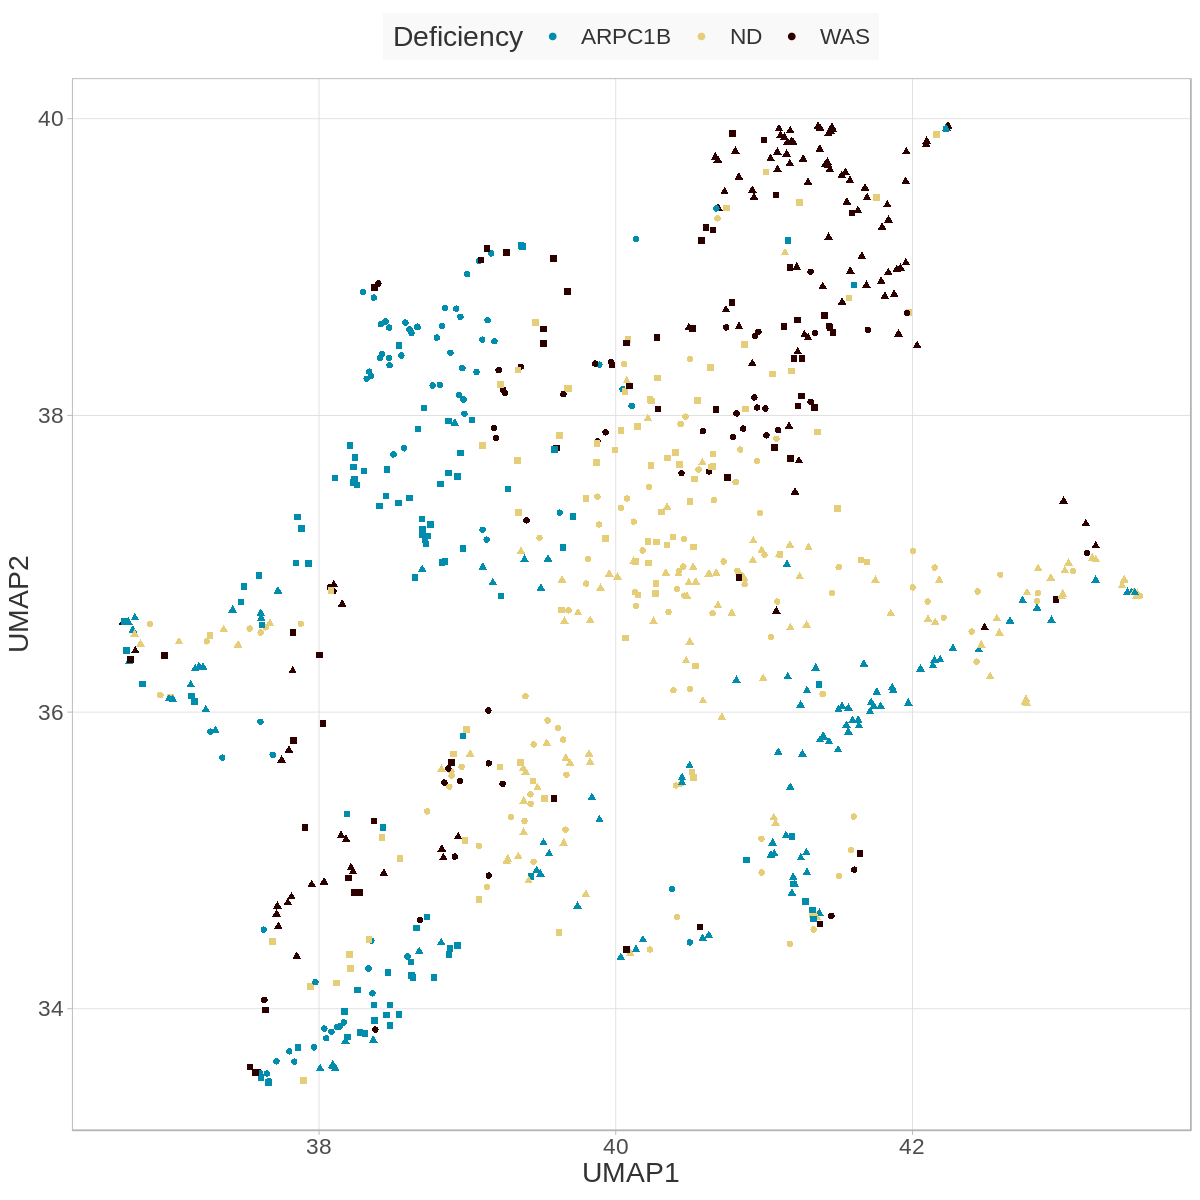

In [38]:
umTLT$Shape = as.factor((as.numeric(as.character(umTLT$Donor))-1)%/%3)
gp <- ggplot(umTLT) + geom_point(aes(UMAP1, UMAP2, color = Deficiency, shape = Shape)) + 
    coord_fixed() + guides(shape=F) + theme(legend.position="top")
gp

In [39]:
if(!TEST_MODE){
    ggsave(filename = "Fig/LT_2Deficiencies_UMAP.pdf", gp, width = 10)
}

Saving 10 x 6.67 in image


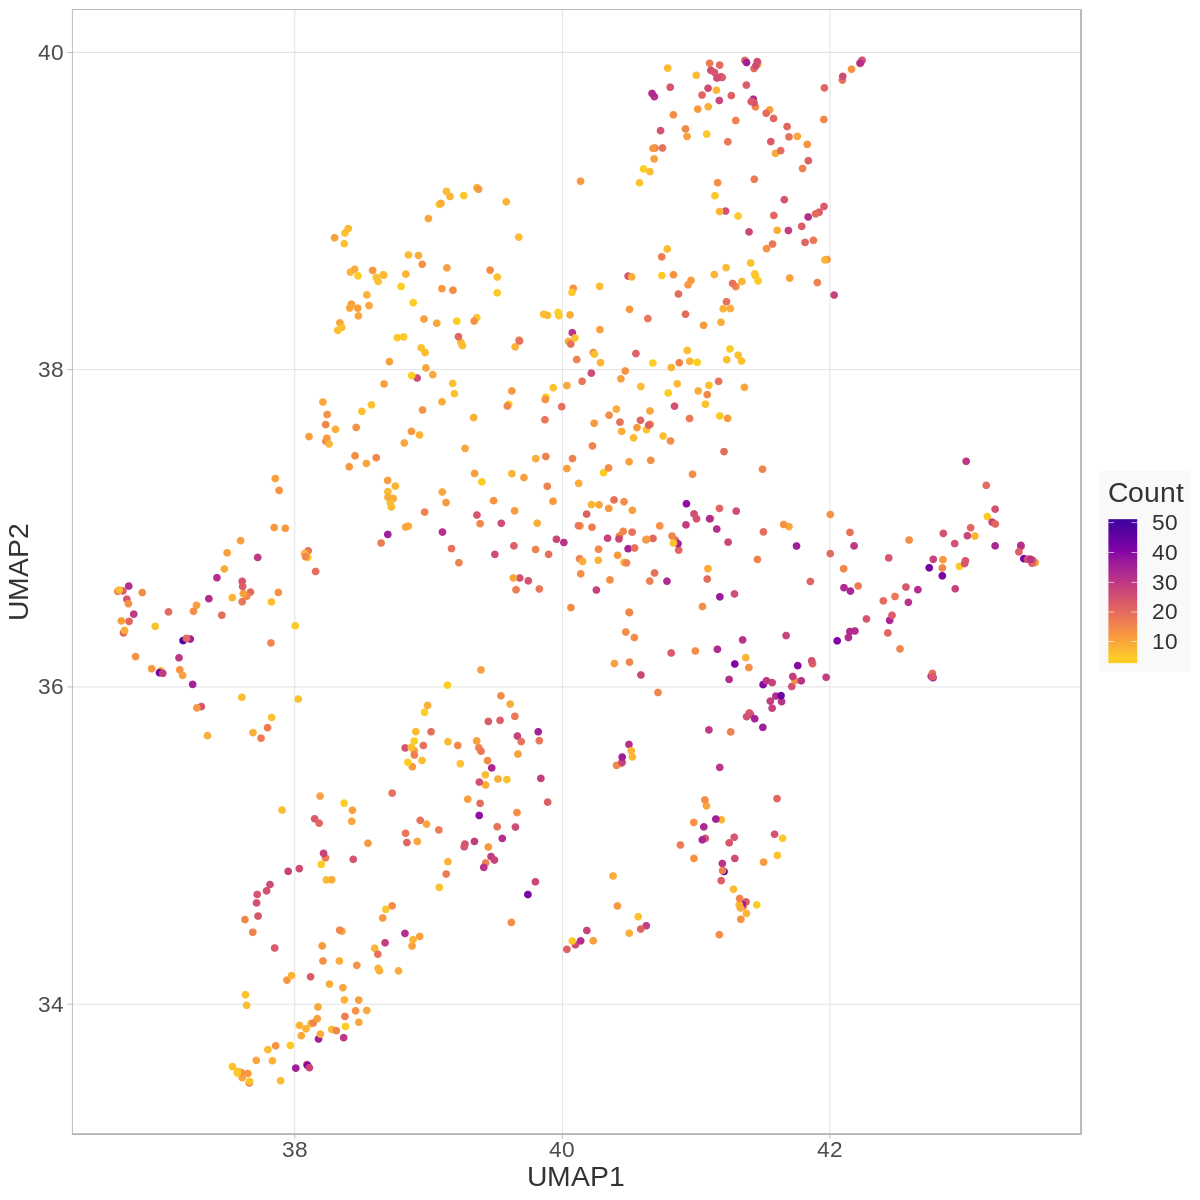

In [40]:
umTLT$Count <- LT$Count_FinalNucleus[fieldToKeep]
gp <- ggplot(umTLT) + geom_point(aes(UMAP1, UMAP2, color = Count))
gp

#### Distances to ND cells

In [41]:
umTLT = umap(transformedLT, min_dist = 0.01, neighbors = 8, n = dimUMAP, metric = "euclidean")
umTLT = as.data.frame(umTLT)
names(umTLT) = paste0("UMAP", 1:dimUMAP)

In [42]:
# Compute the median Robust Mahalanobis Distance (RMD) between drugs
condRMD <- function(donor){
    setUmapDonor = umTLT[(LT[fieldToKeep,]$Donor == donor),1:dimUMAP]
    setUmapWT = umTLT[which((LT[fieldToKeep,]$ND)),1:dimUMAP]
    
    # Ensure that we have enough points to compute distance
    if ((dim(setUmapDonor)[1] < 2*dimUMAP)|(dim(setUmapWT)[1] < 2*dimUMAP)){
            print(donor)
            return(NA)
    }
    
    # Compute Minimum Covariance Determinant and corresponding Robust Mahalanobis Distance
    mcdWT = covMcd(setUmapWT)
    RMD = median(apply(setUmapDonor, 1, function(x) mahalanobis(x, mcdWT$center, mcdWT$cov)))
    return(RMD)
}

In [43]:
shuffCondRMD <- function(donor, nbRep = PERM_NB_ITER){
    setUmapDonor = umTLT[(LT[fieldToKeep,]$Donor == donor),1:dimUMAP]
    setUmapWT = umTLT[which((LT[fieldToKeep,]$ND)),1:dimUMAP]
    setUMAP = rbind(setUmapWT,setUmapDonor)
    shuffleRMD <- function(notUsed){
        shuffSetUMAP = setUMAP[sample(nrow(setUMAP)),]
        # Take random subsets of corresponding sizes
        shuffSetDonor = shuffSetUMAP[1:nrow(setUmapDonor),]
        shuffSetWT = shuffSetUMAP[(nrow(setUmapDonor)+1):(nrow(setUmapDonor)+nrow(setUmapWT)),]
        
        # Ensure that we have enough points to compute distance
        if ((dim(shuffSetDonor)[1] < 2*dimUMAP)|(dim(shuffSetWT)[1] < 2*dimUMAP)){
                print(donor)
                return(NA)
        }
        
        # Compute Minimum Covariance Determinant and corresponding Robust Mahalanobis Distance
        mcdWT = covMcd(shuffSetWT)
        RMD = median(apply(shuffSetDonor, 1, function(x) mahalanobis(x, mcdWT$center, mcdWT$cov)))
        return(RMD)
    }
    return(sapply(1:nbRep, shuffleRMD))
}

In [44]:
getRMPV <- function(x){
    ecdfRMD = ecdf(x[-1])
    return(1 - ecdfRMD(x[1]))
}

In [45]:
RMD_LT = sapply(unique(LT$Donor[fieldToKeep]), function(x) condRMD(x))
shuffRMD_LT = sapply(unique(LT$Donor[fieldToKeep]), function(x) shuffCondRMD(x))
dfRMPV = data.frame(RMPV = apply(rbind(RMD_LT, shuffRMD_LT), 2, getRMPV))
dfRMPV$Donor = rownames(dfRMPV)
dfRMPV$Strength = RMD_LT
dfRMPV$adjRMPV = p.adjust(dfRMPV$RMPV, method = "fdr") 

In [46]:
dfRMPV$Deficiency = rep(c("ND", "WAS", "ARPC1B"), 3)
dfRMPV$Shape = as.factor(rep(1:3, each = 3))

Saving 10 x 6.67 in image


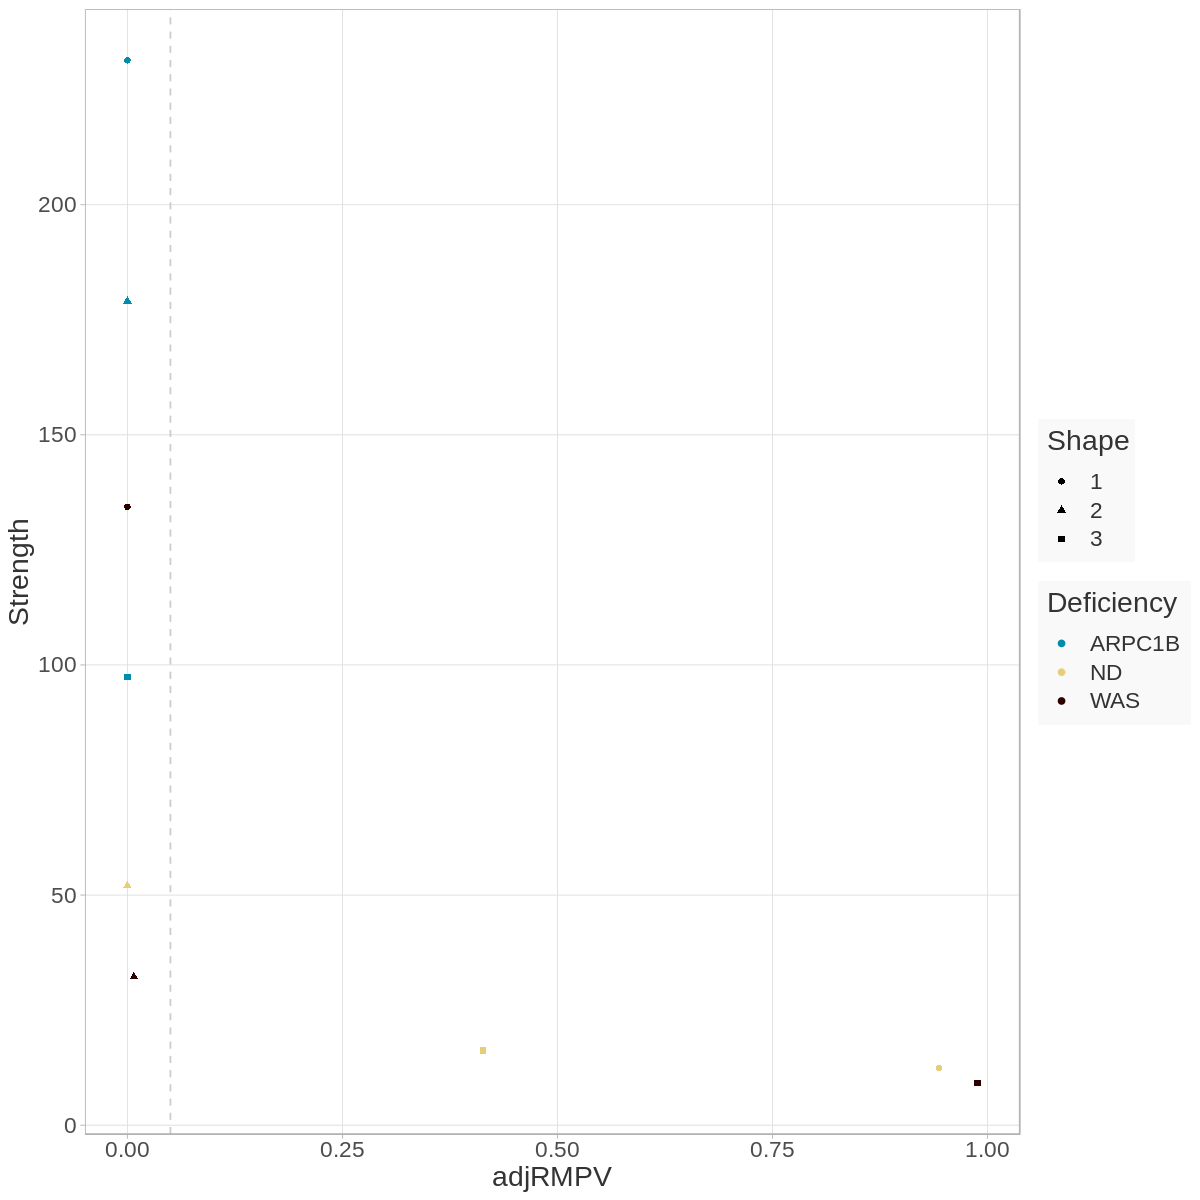

In [47]:
gp <- ggplot(dfRMPV) + geom_point(aes(adjRMPV, Strength, color = Deficiency, shape = Shape)) + 
    geom_vline(xintercept = 0.05, color="#CCCCCC", linetype="dashed") 
print(gp)
if(!TEST_MODE){
    ggsave(filename = "Fig/LT_2Deficiencies_RMPV.pdf", gp, width = 10)
}

### Morphological changes in patients

In [48]:
# Associate categories and colors to features
catType = c("Granularity", "Texture", "AreaShape", "RadialDistribution",
            "Intensity")
colType = cust_pal(length(catType)+1)

dtCount = as.data.frame(sapply(catType, function(x) grepl(x, colnames(transformedLT))))
dtCount$Other = !apply(dtCount, 1, any)
 
ftCat = as.factor(apply(dtCount, 1, function(x) colnames(dtCount)[which(x)]))

# Order levels so that "Other" is last
lvOther = which(levels(ftCat) == "Other")
ftCat = factor(ftCat, levels = c(levels(ftCat)[-lvOther], "Other"))
       
# Corresponding colors
ftCol = colType[ftCat]

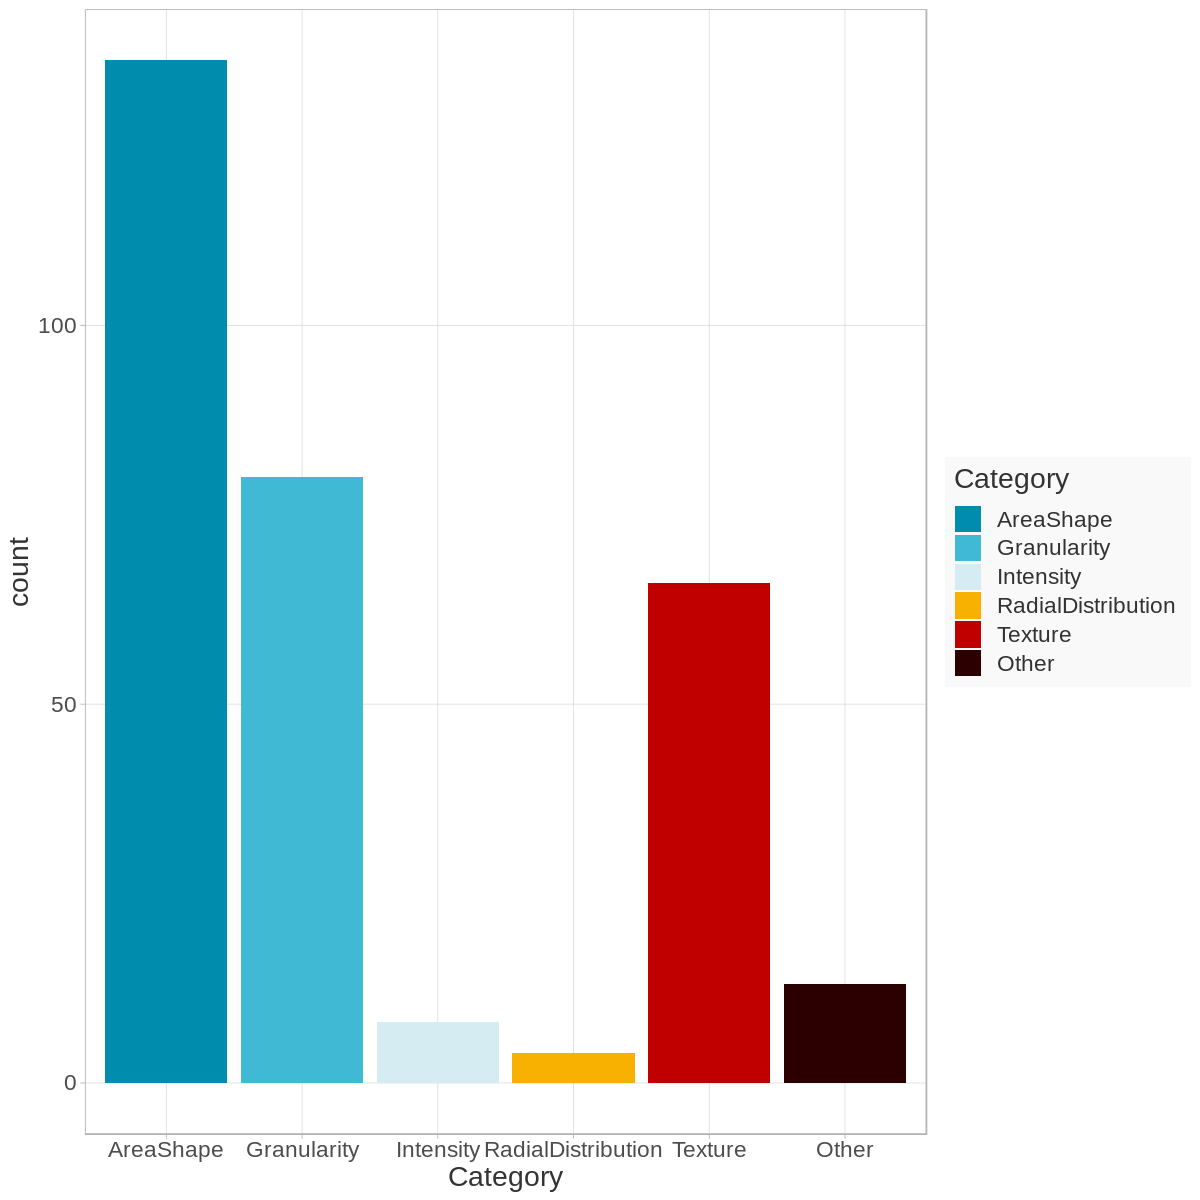

In [49]:
# Plot number of images / categories (useful to get fill color legend)
gp <- ggplot(data.frame(Category = ftCat), aes(fill = Category)) + geom_bar(aes(Category))
print(gp)

## Prediction of disease status based on morphology

5CV + 1 fold validation

In [50]:
set.seed(38)

In [51]:
# Number of images per fold (5CV + validation set)
nbSampTestSet = round(nrow(transformedLT)/6)

In [52]:
# Shuffle images
idImages = sample(nrow(transformedLT))

# Last fold will be used as validation set
validationSet = as.data.frame(transformedLT[-idImages[1:(nbSampTestSet*5)],])
validationSet$Disease = as.factor(LT$Deficiency[fieldToKeep][-idImages[1:(nbSampTestSet*5)]])

table(validationSet$Disease)


ARPC1B     ND    WAS 
    48     46     35 

In [53]:
# F1 score for a given level
F1pred <- function(preds, obs, curLvl){
    TP = sum((preds == curLvl) & (obs == curLvl))
    FP = sum((preds == curLvl) & (obs != curLvl))
    TN = sum((preds != curLvl) & (obs != curLvl))
    FN = sum((preds != curLvl) & (obs == curLvl))
    stopifnot(length(preds) == TP+FP+TN+FN)
    stopifnot(length(obs) == TP+FP+TN+FN)
    return((2*TP)/(2*TP+FN+FP))
}

In [54]:
# Perform random forest cross-validation on a given dataset
crossValRF <- function(dataset, folds, nbSampTestSet, idImages, mtryRange, nbTrees = RF_NB_TREES){
    # Fitness matrix (F1 score between 0 and 1, with 1 optimal)
    fitMat = matrix(ncol = folds, nrow = length(mtryRange))
    rownames(fitMat) <- as.character(mtryRange)
    for (mtryId in 1:length(mtryRange)) {
        curMtry = mtryRange[mtryId]
        print(paste("Mtry", curMtry))
        for (fold in 1:folds) {
            print(paste("Fold", fold))
            foldInd = ((fold-1)*nbSampTestSet+1):(fold*nbSampTestSet)
            testSet = dataset[foldInd,]
            trainSet = dataset[-foldInd,]

            # All classes are present in train and test sets
            stopifnot(length(table(testSet$Disease)) == 3)
            stopifnot(length(table(trainSet$Disease)) == 3)

            rf = randomForest(Disease ~ ., data = trainSet, mtry = curMtry, ntree = nbTrees)

            print(paste("Mean class error", mean(rf$confusion[,3])))
            # Prediction on test set
            preds <- predict(rf, testSet)
            # Accuracy
            print(paste("Accuracy", mean(preds == testSet$Disease)))
            # Macro F1 score
            fitMat[mtryId, fold] = mean(sapply(levels(testSet$Disease), 
                        function(x) F1pred(preds, testSet$Disease, x)))
            flush.console()
        }
    }
    return(fitMat)
}

In [55]:
datasetCV = as.data.frame(transformedLT[idImages[1:(nbSampTestSet*5)],])
datasetCV$Disease = as.factor(LT$Deficiency[fieldToKeep][idImages[1:(nbSampTestSet*5)]])
CM = crossValRF(dataset = datasetCV, folds = 5, nbSampTestSet = nbSampTestSet, 
                idImages = idImages, mtryRange = c(20, 30, 40, 50, 60, 70, 80, 90))

[1] "Mtry 20"
[1] "Fold 1"
[1] "Mean class error 49.6666666666667"
[1] "Accuracy 0.96031746031746"
[1] "Fold 2"
[1] "Mean class error 49.3333333333333"
[1] "Accuracy 0.936507936507937"
[1] "Fold 3"
[1] "Mean class error 50"
[1] "Accuracy 0.952380952380952"
[1] "Fold 4"
[1] "Mean class error 49.6666666666667"
[1] "Accuracy 0.96031746031746"
[1] "Fold 5"
[1] "Mean class error 48.3333333333333"
[1] "Accuracy 0.968253968253968"
[1] "Mtry 30"
[1] "Fold 1"
[1] "Mean class error 50.3333333333333"
[1] "Accuracy 0.96031746031746"
[1] "Fold 2"
[1] "Mean class error 49"
[1] "Accuracy 0.928571428571429"
[1] "Fold 3"
[1] "Mean class error 49"
[1] "Accuracy 0.952380952380952"
[1] "Fold 4"
[1] "Mean class error 49.6666666666667"
[1] "Accuracy 0.96031746031746"
[1] "Fold 5"
[1] "Mean class error 47.3333333333333"
[1] "Accuracy 0.968253968253968"
[1] "Mtry 40"
[1] "Fold 1"
[1] "Mean class error 49.6666666666667"
[1] "Accuracy 0.96031746031746"
[1] "Fold 2"
[1] "Mean class error 48.3333333333333"
[1] "A

In [56]:
CM
rowMeans(CM)
optiMtry = as.numeric(rownames(CM)[rowMeans(CM) == max(rowMeans(CM))])[1]

20,0.9596674,0.9361862,0.9493674,0.9590348,0.9677497
30,0.9596674,0.9289209,0.9493674,0.9585126,0.9677497
40,0.9596674,0.9283690,0.9493674,0.9585126,0.9599224
50,0.9598292,0.9283690,0.9493674,0.9507839,0.9599224
60,0.9511208,0.9133193,0.9493674,0.9264313,0.9604991
70,0.9511208,0.9133193,0.9493674,0.9181540,0.9604991
80,0.9511208,0.9211117,0.9493674,0.9264313,0.9682558
90,0.9439391,0.9211117,0.9493674,0.9181540,0.9605072


20        30        40        50        60        70        80        90 
0.9544011 0.9528436 0.9511678 0.9496544 0.9401476 0.9384921 0.9432574 0.9386159

In [57]:
optiMtry
fullRF = randomForest(Disease ~ ., data = datasetCV, mtry = optiMtry, ntree = RF_NB_TREES, localImp = T)

[1] 20

In [58]:
preds <- predict(fullRF, validationSet)
# Accuracy
print(paste("Validation accuracy", mean(preds == validationSet$Disease)))
# Macro F1-score
mean(sapply(levels(validationSet$Disease), 
            function(x) F1pred(preds, validationSet$Disease, x)))

[1] "Validation accuracy 0.961240310077519"


[1] 0.9610787

In [59]:
fullRF


Call:
 randomForest(formula = Disease ~ ., data = datasetCV, mtry = optiMtry,      ntree = RF_NB_TREES, localImp = T) 
               Type of random forest: classification
                     Number of trees: 1000
No. of variables tried at each split: 20

        OOB estimate of  error rate: 4.6%
Confusion matrix:
       ARPC1B  ND WAS class.error
ARPC1B    215   2   1  0.01376147
ND          4 217  12  0.06866953
WAS         5   5 169  0.05586592

### Output confusion matrix

In [60]:
confMat = data.frame(Observed = rep(levels(validationSet$Disease), each = length(levels(validationSet$Disease))),
                     Predicted = rep(levels(validationSet$Disease), length(levels(validationSet$Disease))),
                     Count = 0)
# Color: white on diagonal (for text readability)
confMat$Color = ifelse(confMat$Observed == confMat$Predicted, "#FFFFFF", "#333333")

In [61]:
for (i in 1:nrow(validationSet)){
    idMat = (confMat$Observed == validationSet$Disease[i]) & (confMat$Predicted == preds[i])
    confMat$Count[idMat] = confMat$Count[idMat] + 1
}

head(confMat)

Observed,Predicted,Count,Color
<fct>,<fct>,<dbl>,<chr>
ARPC1B,ARPC1B,46,#FFFFFF
ARPC1B,ND,1,#333333
ARPC1B,WAS,1,#333333
ND,ARPC1B,1,#333333
ND,ND,45,#FFFFFF
ND,WAS,0,#333333


In [62]:
totalDF = aggregate(confMat$Count, by = list(confMat$Observed), FUN = sum)
names(totalDF) <- c("Observed", "Count")
totalDF$Predicted = "Total"
totalDF$Color = "#FFFFFF"
confMat = rbind(confMat, totalDF)

In [63]:
f1DF = as.data.frame(round(sapply(levels(validationSet$Disease), 
            function(x) F1pred(preds, validationSet$Disease, x)), 2))
names(f1DF) <- "Count"
f1DF$Observed = rownames(f1DF)
f1DF$Predicted = "F1 score"
f1DF$Color = "#333333"
confMat = rbind(confMat, f1DF)

In [64]:
# Re-order labels
levels(confMat$Observed) = c("ARPC1B patients", "Normal donors", "WAS patients")
levels(confMat$Predicted) = c(levels(confMat$Observed), 'Total', 'F1 score')
confMat$Observed = factor(confMat$Observed, 
                          levels =  c("ARPC1B patients", "WAS patients", "Normal donors"))
confMat$Predicted = factor(confMat$Predicted, 
                          levels =  c(rev(levels(confMat$Observed)), 'Total', 'F1 score') )

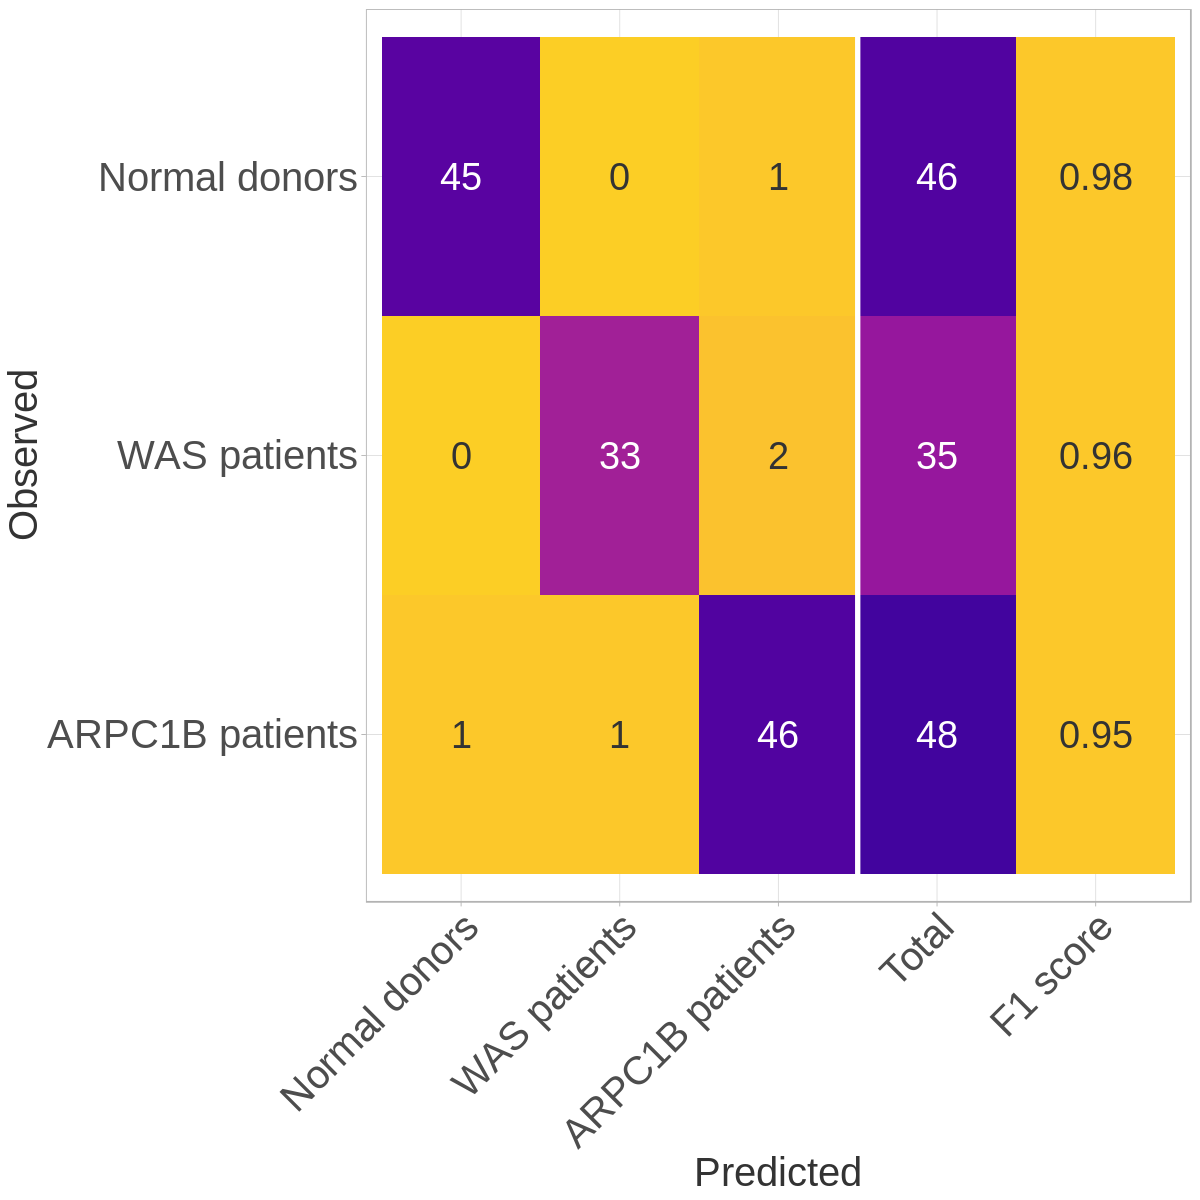

In [65]:
gp <- ggplot(confMat, aes(Predicted, Observed)) + geom_tile(aes(fill = Count)) +
    geom_text(aes(label = Count, color = Color), size = 8) + scale_color_identity() +
    guides(fill = F) + theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1), 
                             axis.text = element_text(size = 24), axis.title = element_text(size = 24)) +
    geom_vline(xintercept = 3.5, color = "#FFFFFF", size = 1.5)
gp

In [66]:
if(!TEST_MODE){
    ggsave(filename = "Fig/LT_2Deficiencies_status_prediction.pdf", plot = gp, width = 10)
}

Saving 10 x 6.67 in image


### Combination of features by feature type and biological object

#### Features important for overall prediction

In [67]:
catObjects = c("FinalNucleus", "FinalCytoplasm", "PerfGranules")
dtCount = as.data.frame(sapply(catObjects, function(x) grepl(x, colnames(transformedLT))))
dtCount$Other = apply(dtCount, 1, function(x) sum(x) != 1)
# Features matching several objects are classified as "Other"
dtCount[dtCount$Other,-4] <- F

In [68]:
ftCatObj = as.factor(apply(dtCount, 1, function(x) colnames(dtCount)[which(x)]))

# Rename to useful names
levels(ftCatObj) <- str_remove(string = levels(ftCatObj), pattern = "Final")
                           
# Order levels so that "Other" is last
lvOther = which(levels(ftCatObj) == "Other")
ftCatObj = factor(ftCatObj, levels = c(levels(ftCatObj)[-lvOther], "Other"))
     
# Combination of feature category and biological object described
combFtCat = paste(ftCat, ftCatObj, sep = " / ")

In [69]:
combImpDF = aggregate(fullRF$importance[,colnames(fullRF$importance) == "MeanDecreaseAccuracy"],
                      by = list(combFtCat), FUN = sum)
combImpDF = cbind(combImpDF, aggregate(fullRF$importance[,colnames(fullRF$importance) == "MeanDecreaseAccuracy"],
                      by = list(combFtCat), FUN = length)[,2], "Cumulated")
names(combImpDF) = c("Type", "Count", "Cardinality", "CountType")
combImpDF$Type = factor(combImpDF$Type, levels = combImpDF$Type[order(combImpDF$Count)])

In [70]:
# Add counts normalized by number of feature in a given type

# Visual correction: a bar with this absolute count will have an average bar of equal size
visNormFactor = 4
relDF = data.frame(Type = combImpDF$Type, 
                   Count = -visNormFactor * combImpDF$Count / combImpDF$Cardinality,
                   Cardinality = NA, CountType = "Average")
combImpDF = rbind(combImpDF, relDF)

Warning message:
“Removed 16 rows containing missing values (geom_text).”

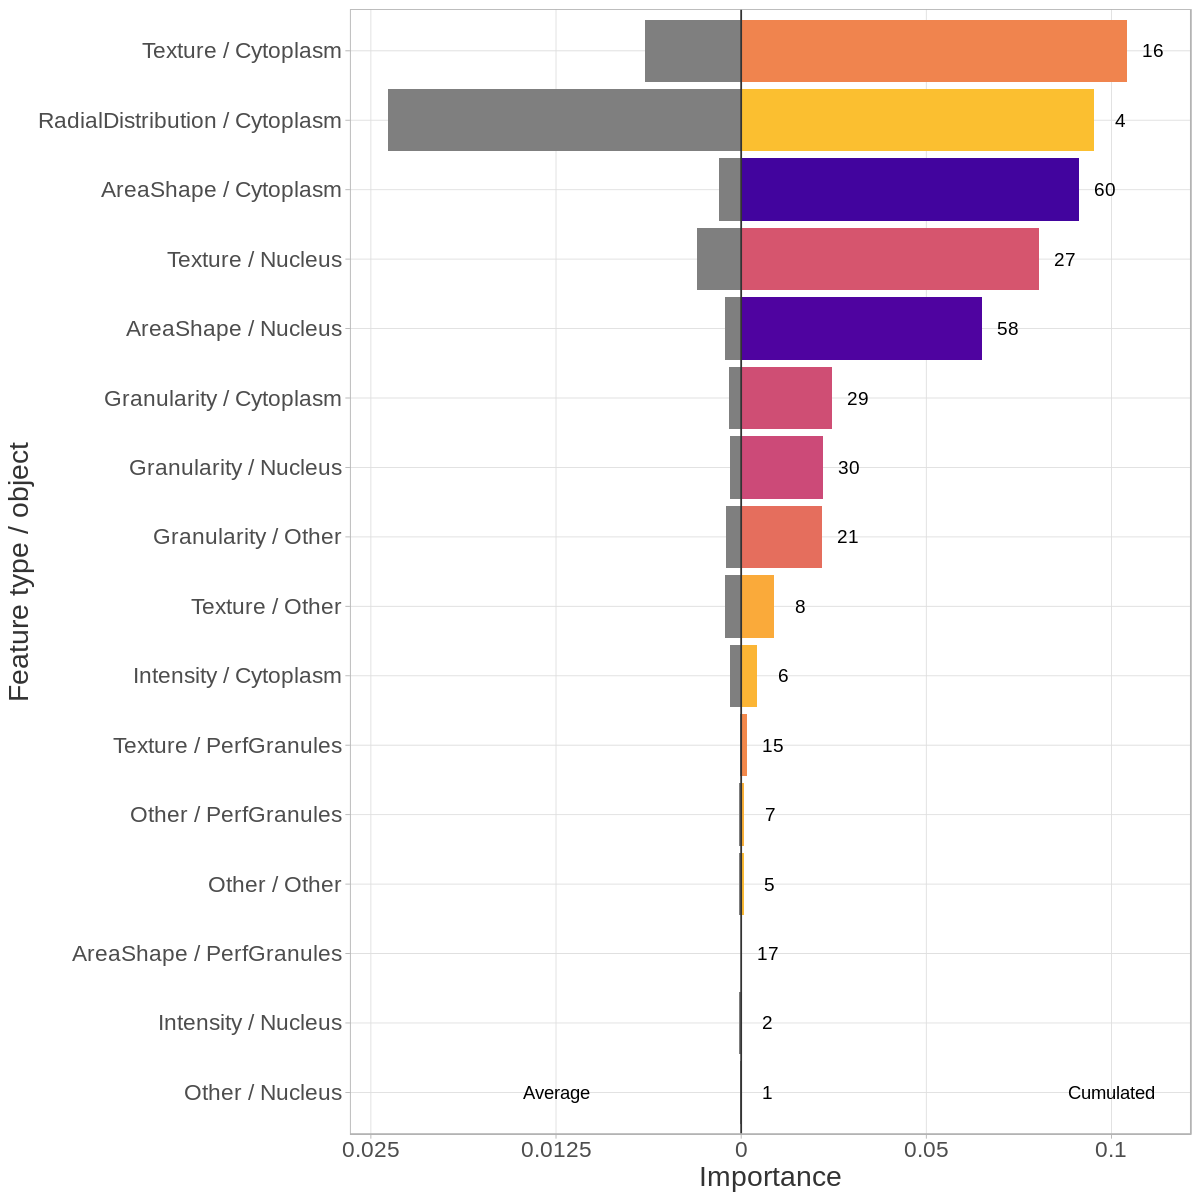

In [71]:
gp <- ggplot(combImpDF) + geom_col(aes(Type, Count, fill = Cardinality)) +
                    xlab("Feature type / object") + ylab("Importance") + coord_flip() +
                    guides(fill = F) + geom_text(aes(x = Type, y = Count + 0.007, label = Cardinality), size = 4) +
                    scale_y_continuous(breaks = seq(-0.5, 0.5, 0.05), 
                                       labels = c(abs(seq(-0.5, -0.001, 0.05)/visNormFactor),seq(0, 0.5, 0.05))) +
                    geom_hline(yintercept = 0, color = "#333333") +
                    annotate("text", x = 1, y = 0.1, label = "Cumulated") +
                    annotate("text", x = 1, y = - 0.05, label = "Average")
gp

In [72]:
if(!TEST_MODE){
    ggsave(filename = "Fig/LT_2Deficiencies_status_prediction_features.pdf", plot = gp, height = 5, width = 10)
}

Warning message:
“Removed 16 rows containing missing values (geom_text).”

#### Features important for ARPC1B prediction

In [73]:
combImpDF = aggregate(fullRF$importance[,colnames(fullRF$importance) == "ARPC1B"],
                      by = list(combFtCat), FUN = sum)
combImpDF = cbind(combImpDF, aggregate(fullRF$importance[,colnames(fullRF$importance) == "ARPC1B"],
                      by = list(combFtCat), FUN = length)[,2], "Cumulated")
names(combImpDF) = c("Type", "Count", "Cardinality", "CountType")
combImpDF$Type = factor(combImpDF$Type, levels = combImpDF$Type[order(combImpDF$Count)])

In [74]:
# Add counts normalized by number of feature in a given type

# Visual correction: a bar with this absolute count will have an average bar of equal size
visNormFactor = 4
relDF = data.frame(Type = combImpDF$Type, 
                   Count = -visNormFactor * combImpDF$Count / combImpDF$Cardinality,
                   Cardinality = NA, CountType = "Average")
combImpDF = rbind(combImpDF, relDF)

Warning message:
“Removed 16 rows containing missing values (geom_text).”

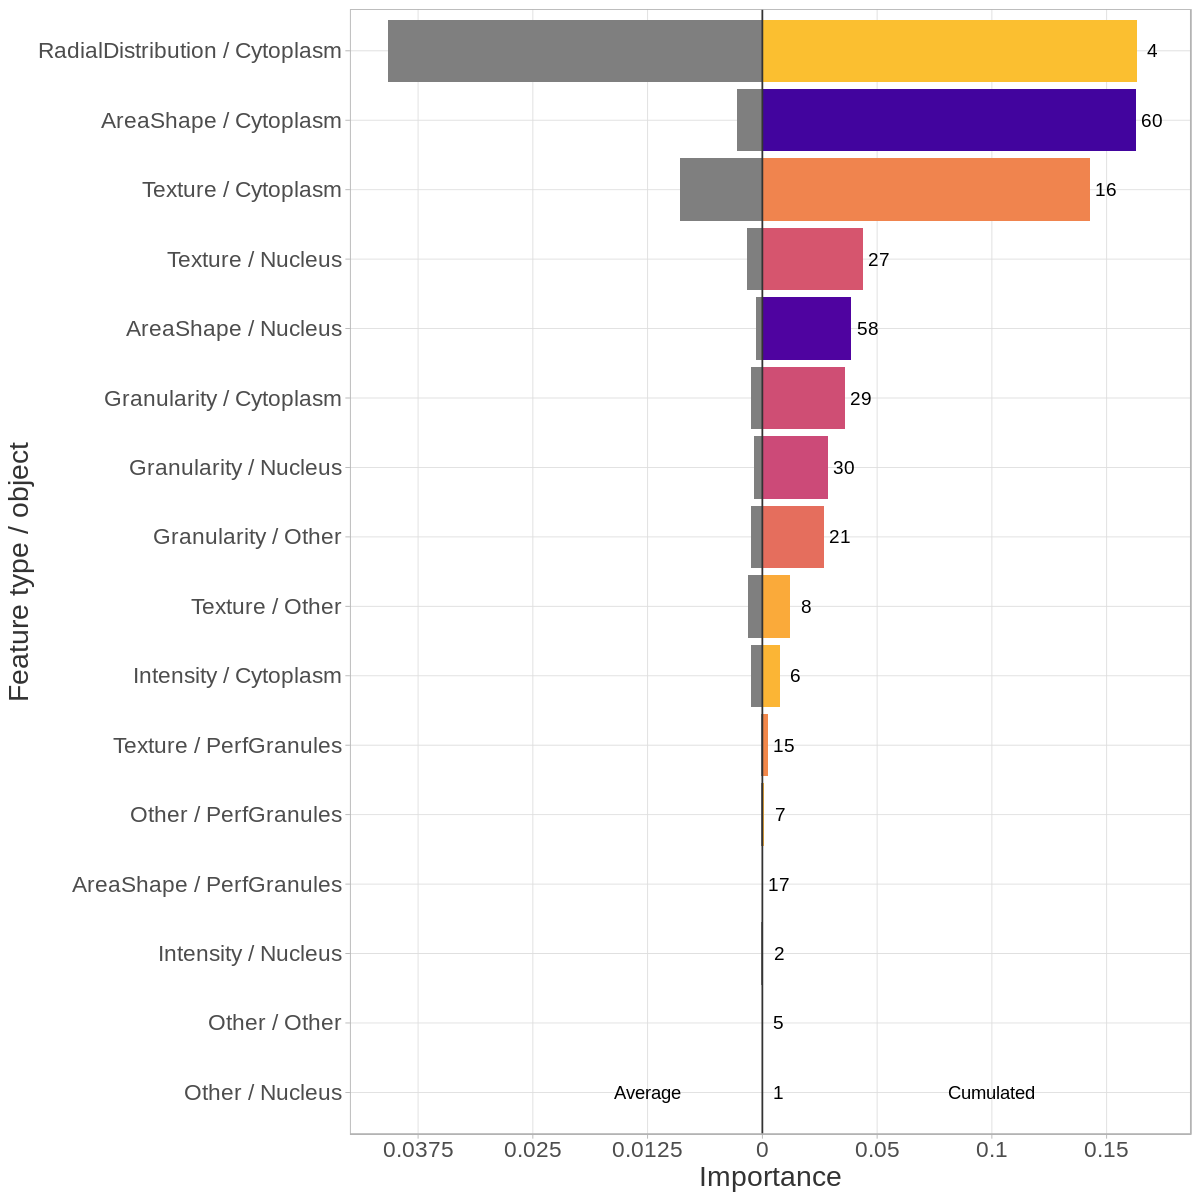

In [75]:
gp <- ggplot(combImpDF) + geom_col(aes(Type, Count, fill = Cardinality)) +
                    xlab("Feature type / object") + ylab("Importance") + coord_flip() +
                    guides(fill = F) + geom_text(aes(x = Type, y = Count + 0.007, label = Cardinality), size = 4) +
                    scale_y_continuous(breaks = seq(-0.5, 0.5, 0.05), 
                                       labels = c(abs(seq(-0.5, -0.001, 0.05)/visNormFactor),seq(0, 0.5, 0.05))) +
                    geom_hline(yintercept = 0, color = "#333333") +
                    annotate("text", x = 1, y = 0.1, label = "Cumulated") +
                    annotate("text", x = 1, y = - 0.05, label = "Average")
gp

In [76]:
if(!TEST_MODE){
    ggsave(filename = "Fig/LT_2Deficiencies_status_prediction_ARPC1B_features.pdf", plot = gp, height = 5, width = 10)
}

Warning message:
“Removed 16 rows containing missing values (geom_text).”

#### Features important for WAS prediction

In [77]:
combImpDF = aggregate(fullRF$importance[,colnames(fullRF$importance) == "WAS"],
                      by = list(combFtCat), FUN = sum)
combImpDF = cbind(combImpDF, aggregate(fullRF$importance[,colnames(fullRF$importance) == "WAS"],
                      by = list(combFtCat), FUN = length)[,2], "Cumulated")
names(combImpDF) = c("Type", "Count", "Cardinality", "CountType")
combImpDF$Type = factor(combImpDF$Type, levels = combImpDF$Type[order(combImpDF$Count)])

In [78]:
# Add counts normalized by number of feature in a given type

# Visual correction: a bar with this absolute count will have an average bar of equal size
visNormFactor = 4
relDF = data.frame(Type = combImpDF$Type, 
                   Count = -visNormFactor * combImpDF$Count / combImpDF$Cardinality,
                   Cardinality = NA, CountType = "Average")
combImpDF = rbind(combImpDF, relDF)

Warning message:
“Removed 16 rows containing missing values (geom_text).”

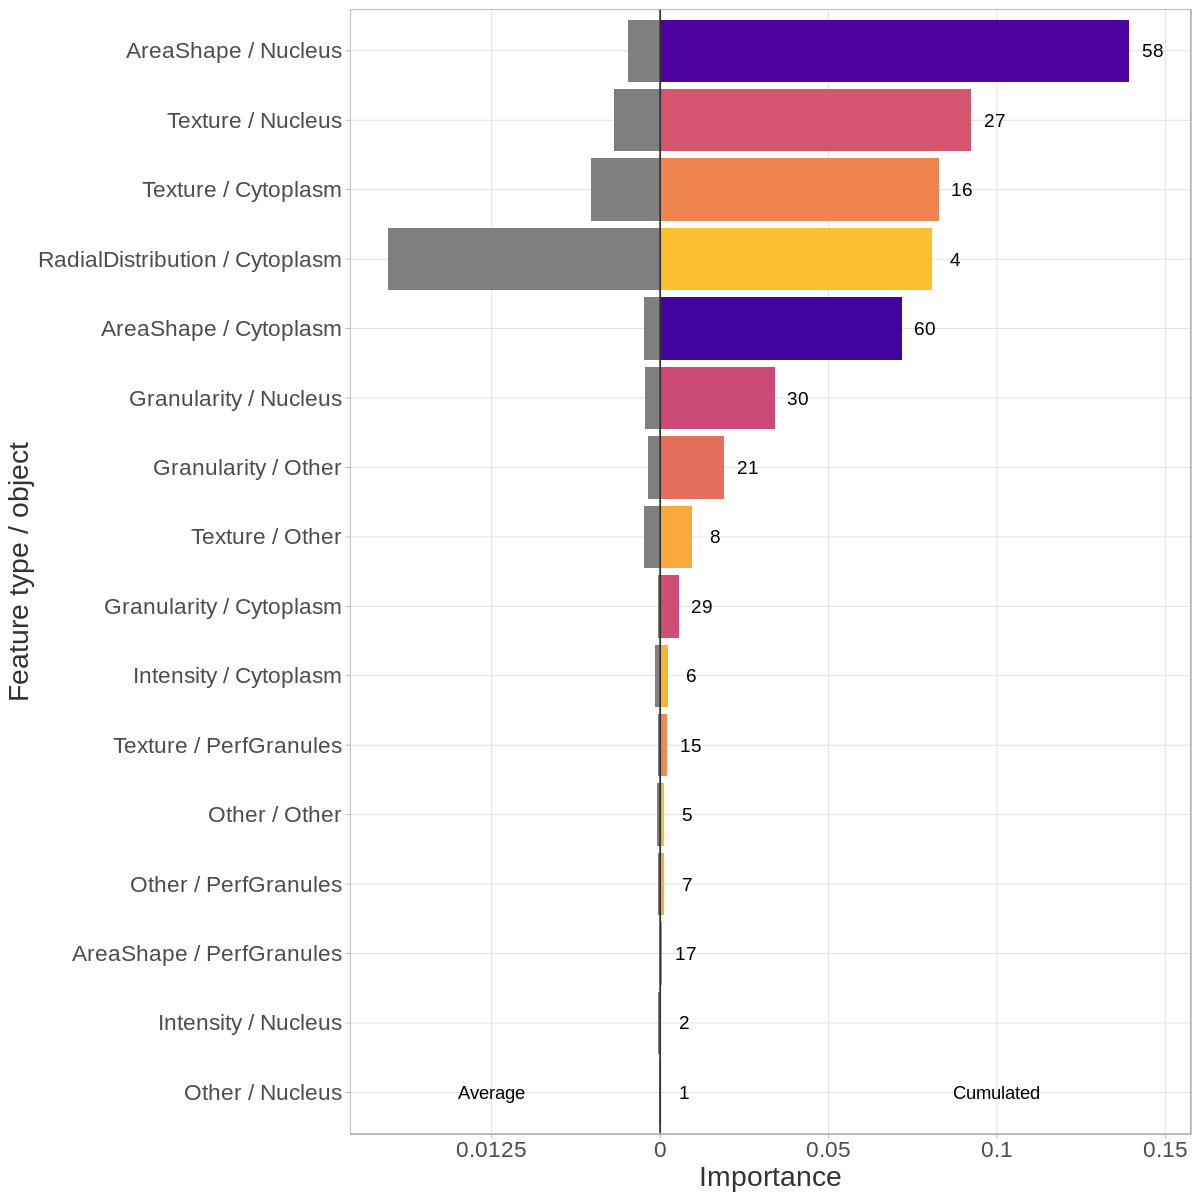

In [79]:
gp <- ggplot(combImpDF) + geom_col(aes(Type, Count, fill = Cardinality)) +
                    xlab("Feature type / object") + ylab("Importance") + coord_flip() +
                    guides(fill = F) + geom_text(aes(x = Type, y = Count + 0.007, label = Cardinality), size = 4) +
                    scale_y_continuous(breaks = seq(-0.5, 0.5, 0.05), 
                                       labels = c(abs(seq(-0.5, -0.001, 0.05)/visNormFactor),seq(0, 0.5, 0.05))) +
                    geom_hline(yintercept = 0, color = "#333333") +
                    annotate("text", x = 1, y = 0.1, label = "Cumulated") +
                    annotate("text", x = 1, y = - 0.05, label = "Average")
gp

In [80]:
if(!TEST_MODE){
    ggsave(filename = "Fig/LT_2Deficiencies_status_prediction_WAS_features.pdf", plot = gp, height = 5, width = 10)
}

Warning message:
“Removed 16 rows containing missing values (geom_text).”

In [81]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.1 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/lib/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] reshape2_1.4.3      randomForest_4.6-14 robustbase_0.93-3  
 [4] gridExtra_2.3       reticulate_1.10     ggrepel_0.8.0      
 [7] heatmaply_0.15.2    viridis_0.5.1       viridisLite_0.3.0  
[10] plotly_4.8.0        stringr_1.4.0       extrafont_0.17     
[13] ggplot2_3.1.1      

loaded via a namespace (and not attached):
 